## Advanced Lane Line Detection

This project deals with determining lane lanes by a series of procedures as follows:
 
- Camera Calibration
- Undistort the image
- Colour and Gradient Threshold
- Perspective Transform
- Identify lane lines by Histogram Peaks
- Measure the radius of Curvature and Fit the polynomial for Straight and Curvy Lanes.

## Section 1: Camera Calibration

- Images are shown below which are present in the calibration directory.
- Camera Calibration function returns Camera Matrix and Distortion coefficients.
- 9,6 configuration is used to find the checkboard corners.
- cv2.caliberateCamera function is used to find out camera matrix and distortion coefficients.
- Undistort function uses the camera matrix and distortion coefficients to undistrt the image.

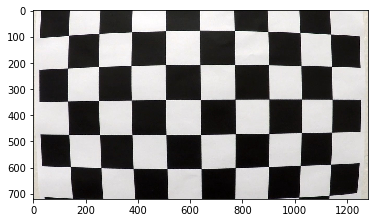

In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob2
from moviepy.editor import VideoFileClip
import math


%matplotlib inline
%matplotlib inline

ex_image = mpimg.imread('camera_cal/calibration1.jpg')

#Example
plt.imshow(ex_image)
plt.show()

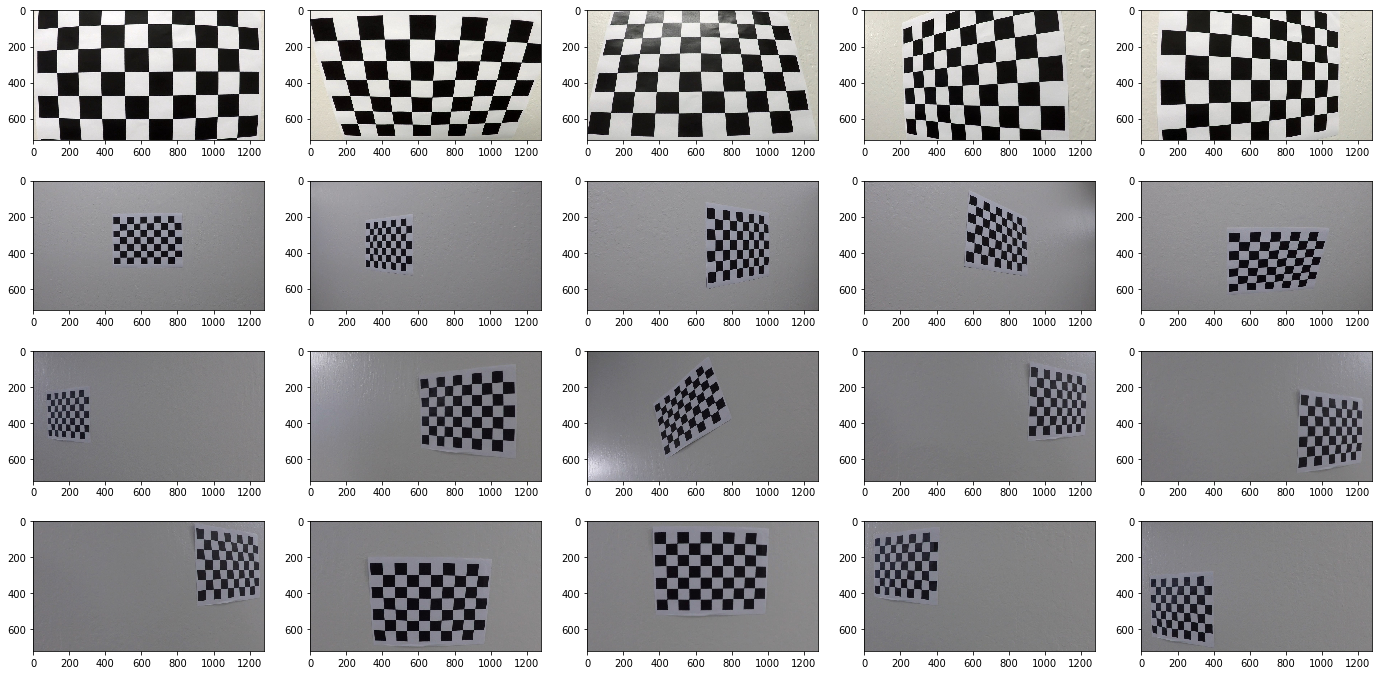

In [2]:
path = ['camera_cal/calibration'+str(i)+'.jpg' for i in range(1,21)]


fig, ax = plt.subplots(4,5)
fig.set_size_inches(24,12)

for i, j in np.ndindex((5,4)):
    ax[j][i].imshow(mpimg.imread(path[j*5+i]))
    
plt.show()

In [3]:

def camera_Calibraton(directory, filename, nx, ny, img_size):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []

    # Image List
    images = glob2.glob('./'+directory+'/'+filename+'*'+'.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
    return mtx, dist

## Section 2: Undistorting the image

In [4]:
def undistort(image, mtx, dist):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

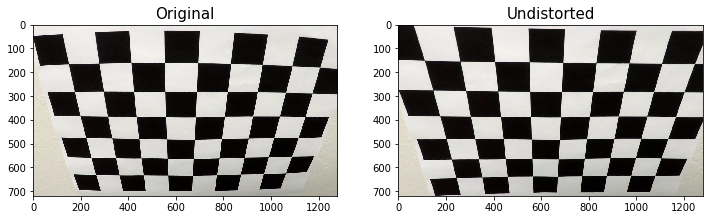

In [5]:
mtx, dist = camera_Calibraton('camera_cal', 'calibration', 9, 6, (720, 1280))
checker_distorted = mpimg.imread("./camera_cal/calibration2.jpg")
checker_undistorted = undistort(checker_distorted, mtx, dist)



f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
ax1.imshow(checker_distorted)
ax1.set_title('Original', fontsize=15)
ax2.imshow(checker_undistorted)
ax2.set_title('Undistorted', fontsize=15)

## Section 3: Gradient Threshold

- The Sobel operator is the heart of Canny Edge Detection and it can be applied in two directions.
- orient is used as x because it emphasizes edges closer to vertical which we are interested in.
- The image has to be converted to gray scale and threshold values are set.
- Gradient threshold is calculaetd in the function abs_sobel_threshold.


In [6]:
def abs_sobel_threshold(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if(orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Return this mask as your binary_output image
    return sbinary

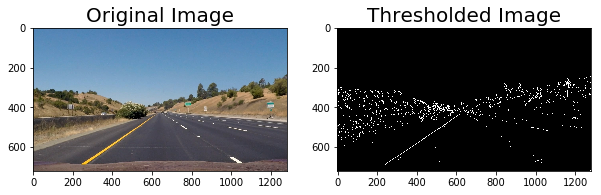

In [7]:
img = mpimg.imread('test_images/straight_lines1.jpg')

sxbinary = abs_sobel_threshold(img, orient='x', thresh_min=20, thresh_max=100)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(sxbinary, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
plt.savefig('output_images/sobel_x', bbox_inches='tight')
plt.show()

- Magnitude of the gradient is calculated by square root of sum of squares.
- Threshold to the overall magnitude of the gradient in both x and y is applied.
- Direction of the Gradient is calculated as we are interested in edges of particular orientation. 
- Direction of the gradient is calculated by inverse tangent of y gradient divided by x gradient. This is performed by arctan function.
- Combining thresholding is done by apply_threshold function which would take magnitude, direction and sobel gradient measurements of x and y to focus on pixels which might be a part of lane lines.

In [8]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    gradmag = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag>=mag_thresh[0]) & (gradmag<=mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    # Remove this line
    return binary_output

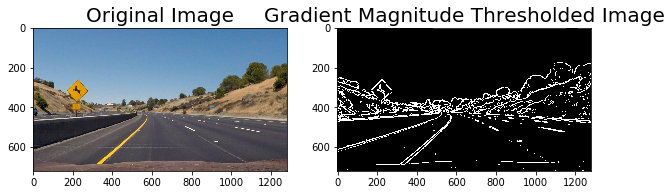

In [9]:
img = mpimg.imread('test_images/test2.jpg')

mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(40,255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Gradient Magnitude Thresholded Image', fontsize=20)
plt.show()

In [10]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(sobely, sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary = np.zeros_like(absgraddir)
    
    # 6) Return this mask as your binary_output image
    binary[(absgraddir>=thresh[0]) & (absgraddir<=thresh[1])] = 1
    
    return binary

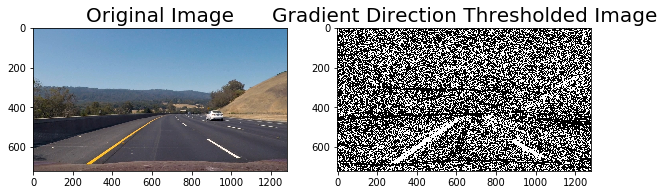

In [11]:
img = mpimg.imread('test_images/test3.jpg')

thresholded = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Gradient Direction Thresholded Image', fontsize=20)
plt.show()

In [12]:
def apply_threshold(img):
    # X threshold
    gradx = abs_sobel_threshold(img, orient='x', thresh_min=30, thresh_max=100)
    
    # Y threshold
    grady = abs_sobel_threshold(img, orient='y', thresh_min=30, thresh_max=100)
    
    # Magnitude threshold
    mag = mag_thresh(img, sobel_kernel=9, mag_thresh=(30,100))
    
    # Direction threshold
    direction = dir_threshold(img, sobel_kernel=15, thresh=(0.7,1.3))
    
    # Combining All
    binary = np.zeros_like(direction)
    
    binary[((gradx == 1) & (grady == 1))|((mag == 1) & (direction == 1))] = 1
    
    return binary

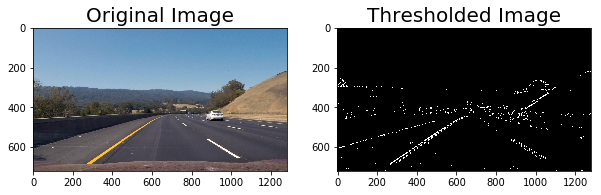

In [13]:
img = mpimg.imread('test_images/test3.jpg')

thresholded = apply_threshold(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
plt.savefig('output_images/multiple_thresholds', bbox_inches='tight')
plt.show()

## Colour Channels:

- For example, I have shown images with 2 colour channels.
- I consider 2 colour channels RGB and HSV.
- R channel in RGB is considered important because it does good job of highlighting lane lines.
- S channel in HSV is considered because it is more robust to lane lines of different colour and handles shadow conditions on the road.
- Next there is a combination of threshold between gradient and S channel threshold.
- b channel is not considered in rg_threshold function because it is not recognised in the gray image.
- grad_thresh function performs the overall gradient and color threshold for the pipeline considering light and saturation level color channels with x sobel operator thresholds.
- Their magnitude and direction is both considered to get clear emphasis on the lane marking.


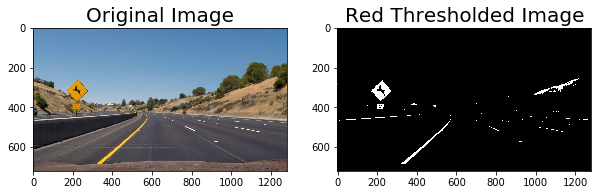

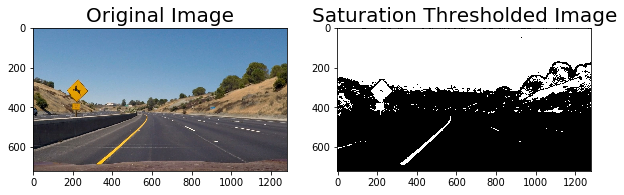

In [14]:
image = mpimg.imread('test_images/test2.jpg')
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Red Thresholded Image', fontsize=20)
plt.savefig('output_images/red_thresholded', bbox_inches='tight')
plt.show()

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Saturation Thresholded Image', fontsize=20)
plt.savefig('output_images/saturation_thresh', bbox_inches='tight')
plt.show()

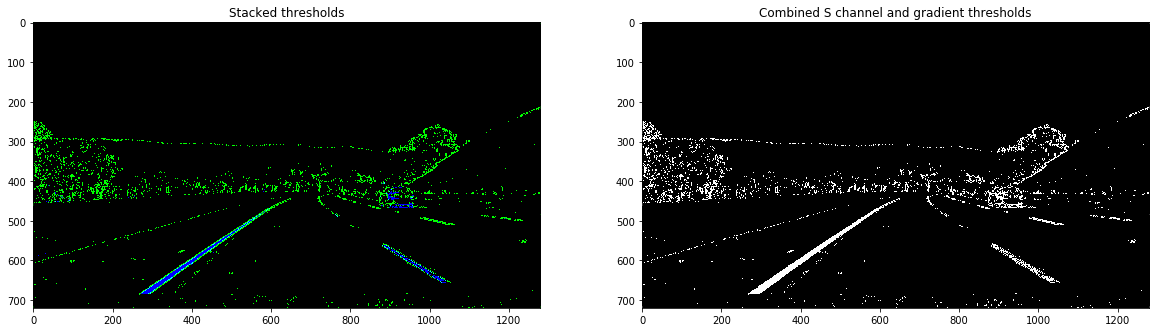

In [15]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))*255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.savefig('output_images/combined_gradients', bbox_inches='tight')

In [16]:
def rg_threshold(img,r_thresh=(150,255), g_thresh=(150,255)):
    r=img[:,:,0]
    g=img[:,:,1]
    
    #b channel not considered because it is not recognised in the gray image
    b_rg = np.zeros_like(gray)
    b_rg[((r>r_thresh[0])&(r<=r_thresh[1]))&((g>g_thresh[0])&(g<=g_thresh[1]))] = 1
    return b_rg

def hsv_threshold(img, h_thresh=(15,100), s_thresh=(90,255), v_thresh=(200,255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h=hsv[:,:,0]
    s=hsv[:,:,1]
    v=hsv[:,:,2]
    
    b_hsv = np.zeros_like(h)
    b_hsv[((h>h_thresh[0])&(h<=h_thresh[1]))&((s>s_thresh[0])&(s<=s_thresh[1]))&((v>v_thresh[0])&(v<=v_thresh[1]))] = 1
    return b_hsv

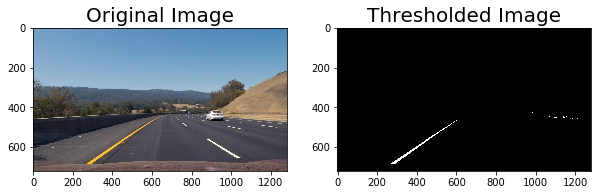

In [17]:
img = mpimg.imread('test_images/test3.jpg')
hsv_thresholded = hsv_threshold(img, h_thresh=(15,100), s_thresh=(90,255), v_thresh=(200,255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hsv_thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
plt.savefig('output_images/hs_thresh', bbox_inches='tight')
plt.show()

In [18]:
def grad_thresh(img):
    
    
    
    magnitude_thresh_s = (20,20)
    magnitude_thresh_l = (20,20)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    
    sobelx_s = cv2.Sobel(s, cv2.CV_64F, 0, 1, ksize = 9)
    sobely_s = cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize = 9)
   
    magnitude_s = np.sqrt(sobelx_s**2+sobely_s**2)
    
    magnitude_s = np.uint8(255*magnitude_s/np.max(magnitude_s))
    
    
    sobelx_l = cv2.Sobel(l, cv2.CV_64F, 0, 1, ksize = 9)
    sobely_l = cv2.Sobel(l, cv2.CV_64F, 1, 0, ksize = 9)
   
    magnitude_l = np.sqrt(sobelx_l**2+sobely_l**2)
    
    magnitude_l = np.uint8(255*magnitude_l/np.max(magnitude_l))
    
    binary = np.zeros_like(magnitude_s)
    binary[((magnitude_s>=magnitude_thresh_s[0]) & (magnitude_s<=magnitude_thresh_s[1]))|((magnitude_l>=magnitude_thresh_l[0])&(magnitude_l<=magnitude_thresh_l[1]))] = 1
    
    return binary
    
    grad_x = abs_sobel_threshold(img, orient='x', thresh_min=20, thresh_max=255)
    grad_m = mag_thresh(img, sobel_kernel=3, mag_thresh=(20,255))
    grad_d = dir_threshold(img, sobel_kernel=29, thresh=(0.7,1.3))
    
    binary_gradient = np.zeros_like(grad_x)
    binary_gradient[((grad_x==1)|(grad_m==1))] = 1
    
    return binary_gradient

## Section 4: Perspective Transform

- This section performs Perspective Transform by warping the image.
- We are interested in creating the bird's eye view of all lane images.
- Source and destination points are marked. They are used to calculate both perspective Transform and Inverse Perspective Transform.
- Different values of hue,saturation and value are selected to emphasize both yellow and white lanes.

In [19]:
def warp(img, src, dst): 
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # get warped image
    warped = cv2.warpPerspective(img, M, img.shape[0:2][::-1], flags=cv2.INTER_LINEAR)
    return warped, Minv

def process_image(img, mtx, dist):
    img = undistort(img, mtx, dist)
    
    src = np.float32([
            [520.847, 450.627],
            [760.153, 450.627],
            [1016.4462, img.shape[0]],
            [263.5538, img.shape[0]]
        ])
    
    dst = np.float32([
            [0, 0],
            [1280, 0],
            [914.638, img.shape[0]],
            [365.362, img.shape[0]]
        ])
    
    img, Minv = warp(img, src, dst)
    
    return img, Minv


In [20]:
def get_lanes(img):
    b_hs_yellow = hsv_threshold(img=img, h_thresh=(15,100), s_thresh=(90,255), v_thresh=(200,255))
    b_hs_white = hsv_threshold(img=img,h_thresh=(0,255), s_thresh=(0,40), v_thresh=(220,255))
    
    b = np.zeros_like(b_hs_yellow)
    
    b_grad = grad_thresh(img)
    
    b[(b_hs_white == 1)|(b_hs_yellow == 1)|(b_grad==1)] = 1
    
    return b

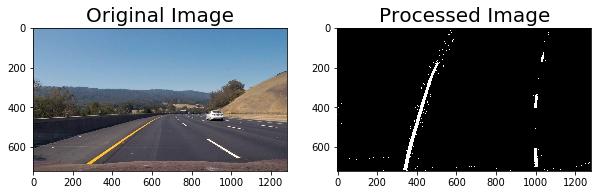

In [21]:
img = mpimg.imread('test_images/test3.jpg')
processed, Minv = process_image(img, mtx, dist)

lines = get_lanes(processed)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(lines, cmap='gray')
ax2.set_title('Processed Image', fontsize=20)
plt.savefig('output_images/binary_warped', bbox_inches='tight')
plt.show()


## Section 5: Identify Peaks in the Histogram 

- Test the bottom of the image to find the peaks of the histogram.
- This is a possibility of giving the lanes information.
- That peaks give the x positions in the image and then keeping that as the reference, using sliding window approach, we go the top of the picture to find all the relevant peaks of the histograms to find the lanes.

## Section 6: Fit the polynomial and find the radius of curvature

- x and y positions are taken from the previous function and they are fit with a second degree polynomial function.
- The calculated radius of curvature has to be calculated on to the real world space.
- The lane width can be considered as per standard pixel space per metres and radius of curvature is calculated accordingly for real space.
- The whole pipeline is implemented in Line Class and video is also embedded.


In [22]:
class Line(object):
    
    def __init__(self):
        self.plot = False
    
    def should_plot(self, plot = False):
        self.frames_processed = 0
        self.plot = plot
        
    def apply_on_video(self, input_video = "project_video.mp4", output_video = "project_video_output.mp4", plot = False):
        self.plot = plot
        
        self.frames_processed = 0
        self.left_fit = None
        self.right_fit = None
        self.out_img = None
        
        # Import everything needed to edit/save/watch video clips
        from moviepy.editor import VideoFileClip
        from IPython.display import HTML

        set_prev = 0
        do_diagnosis = 1

        clip4 = VideoFileClip(input_video);
        white_clip = clip4.fl_image(self.apply_pipeline) #NOTE: this function expects color images!!
        %time white_clip.write_videofile(output_video, audio=False);
        
        HTML("""
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>

        """.format(output_video))
        
    def apply_pipeline(self,img):
        global left_fit
        global right_fit
        global out_img
        
        '''Udistort Image'''
        img = undistort(img, mtx, dist)

        if(self.plot):
            f, ((ax11, ax12),(ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 7))
            ax11.imshow(img)
            ax11.set_title('Undistorted Image', fontsize=20)

        '''Warp Image'''
        src = np.float32([
            [560.847, 445.627],
            [720.153, 445.627],
            [1016.4462, img.shape[0]],
            [263.5538, img.shape[0]]
        ])

        dst = np.float32([
            [0, 0],
            [1280, 0],
            [914.638, img.shape[0]],
            [365.362, img.shape[0]]
            ])

        
        
        
        
            
        warped, Minv = warp(img, src, dst)
        binary_warped = get_lanes(warped)
        
        if(self.plot):
            ax12.imshow(binary_warped, cmap='gray')
            ax12.set_title('Binary Image', fontsize = 20)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        #window_img=np.zeros_like(out_img)##########################################

        if(self.frames_processed == 0):
            # Find Lines
            # Assuming you have created a warped binary image called "binary_warped"
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
            
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = 100
            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        else:
            # Assume you now have a new warped binary image 
            # from the next frame of video (also called "binary_warped")
            
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 100
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        if(self.plot):
            ax21.imshow(out_img)
            ax21.plot(left_fitx, ploty, color='yellow')
            ax21.plot(right_fitx, ploty, color='yellow')
            ax21.set_title('Polynomials', fontsize = 20)

        # Draw on Image
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        #ploty = np.linspace(0, 719, num=720)##############################################
        y_eval = np.max(ploty)
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720.0 # meters per pixel in y dimension
        xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
        
        
        #left_fit = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)#######################
        #right_fit = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)#######################
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
        left_pos = (left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2])
        right_pos = (right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2])
        
        lanes_mid = (left_pos+right_pos)/2.0
        
        distance_from_mid = binary_warped.shape[1]/2.0 - lanes_mid
        
        mid_dist_m = xm_per_pix*distance_from_mid
        
        curvature = 'Radius: '+ str(left_curverad) + ' m, ' + str(right_curverad) + " m"
        lane_dist = 'Distance From Road Center: '+str(mid_dist_m)+' m'
        font = cv2.FONT_HERSHEY_SIMPLEX
        result = cv2.putText(result,curvature,(25,50), font, 1, (255,255,255),2,cv2.LINE_AA)
        result = cv2.putText(result,lane_dist,(25,100), font, 1, (255,255,255),2,cv2.LINE_AA)

        if(self.plot):
            ax22.imshow(result)
            ax22.set_title('Processed Image', fontsize = 20)
            plt.savefig('output_images/pipeline', bbox_inches='tight')
            
        self.frames_processed = self.frames_processed + 1

        # Return
        return result

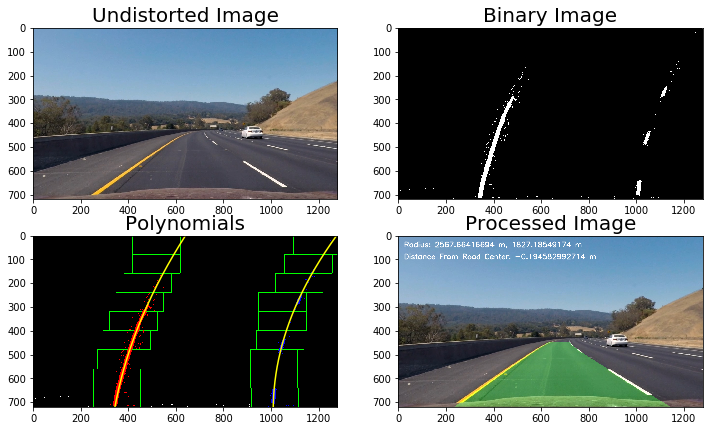

In [23]:
mg = mpimg.imread('test_images/test2.jpg')
LF = Line()
LF.should_plot(True)
result = LF.apply_pipeline(img)

In [73]:
LF.apply_on_video(input_video='project_video.mp4',output_video='project_video_out.mp4')


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:17<00:00,  4.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 4min 19s


In [74]:
from IPython.display import HTML
project_output='project_video_output'
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format("project_video_out.mp4"))